<font size='10'><h1 align="center"><font color='blue'>iPy oxDNA Examples</font></h1>

<center>
<img src="oxDNA.png">
</center>

<font size='10'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Duplex Melting</font></h2> 

In [1]:
from ipy_oxdna.umbrella_sampling import MeltingUmbrellaSampling
from ipy_oxdna.oxdna_simulation import SimulationManager, Simulation, Observable
from ipy_oxdna.vmmc import *

import os
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

<font size='10'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Potential Energy Umbrella Temperature Interpolation</font></h2> 

In [2]:
path = os.path.abspath('/scratch/mlsample/ipy_oxDNA/ipy_oxdna_examples/duplex_melting/')

system_name = 'external_force_file'

conditions = ['5']

systems = [f'duplex_52_{stiff}_test' for stiff in conditions]

file_dirs = [f'{path}/{system_name}' for _ in range(len(systems))]


xmin = 0
xmax = 15
n_windows = 100
starting_r0 = 0.4213
stiff = 5
print_every = 1e4
temperature = '52C'
name = 'all_observables.txt'

pre_eq_steps = 5e6
eq_steps = 1e8
prod_steps = 1e9

verlet_skin = 0.5

hb_contact_filename = 'hb_contacts.txt'

com_list = ','.join('8,9,10,11,12,13,14,15'.split(',')[::-1])
ref_list = '0,1,2,3,4,5,6,7'

particle_indexes = [com_list, ref_list]
hb_contact_observable = [{'idx':particle_indexes, 'name':f'{hb_contact_filename}', 'print_every':int(print_every)}]


pre_equlibration_parameters_list = [{'backend':'CPU',"CUDA_list": "no",'use_edge': 'false','steps':f'{pre_eq_steps}','print_energy_every': f'{pre_eq_steps}',
                           'print_conf_interval':f'{pre_eq_steps}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}' }
                            for _ in conditions]

equlibration_parameters_list = [{'backend':'CPU',"CUDA_list": "no",'use_edge': 'false','steps':f'{eq_steps}','print_energy_every': f'{eq_steps}',
                           'print_conf_interval':f'{eq_steps/10}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}'}
                            for _ in conditions]

production_parameters_list = [{'backend':'CPU',"CUDA_list": "no",'use_edge': 'false','steps':f'{prod_steps}','print_energy_every': f'{prod_steps}',
                           'print_conf_interval':f'{prod_steps/10}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}'}
                            for _ in conditions]

us_list = [MeltingUmbrellaSampling(file_dir, sys, clean_build='force') for file_dir, sys in zip(file_dirs,systems)]
simulation_manager = SimulationManager()

In [3]:
for us, pre_equlibration_parameters in zip(us_list, pre_equlibration_parameters_list):
    print(us.system)
    us.build_pre_equlibration_runs(simulation_manager, n_windows, com_list, ref_list,
                               stiff, xmin, xmax, pre_equlibration_parameters, starting_r0, pre_eq_steps,
                               print_every=print_every, observable=True, protein=None,
                               force_file=True, continue_run=False, name=name, custom_observable=hb_contact_observable)

duplex_52_5_test


In [10]:
force_js = us_list[0].us_build.force_group_name(us_list[0].pre_equlibration_sims)
force_js.values()

dict_values([{'type': 'mutual_trap', 'particle': '0', 'ref_particle': '15', 'stiff': '0.001', 'r0': '1.2', 'PBC': '1'}, {'type': 'mutual_trap', 'particle': '1', 'ref_particle': '14', 'stiff': '0.001', 'r0': '1.2', 'PBC': '1'}, {'type': 'mutual_trap', 'particle': '2', 'ref_particle': '13', 'stiff': '0.001', 'r0': '1.2', 'PBC': '1'}, {'type': 'mutual_trap', 'particle': '3', 'ref_particle': '12', 'stiff': '0.001', 'r0': '1.2', 'PBC': '1'}, {'type': 'mutual_trap', 'particle': '4', 'ref_particle': '11', 'stiff': '0.001', 'r0': '1.2', 'PBC': '1'}, {'type': 'mutual_trap', 'particle': '5', 'ref_particle': '10', 'stiff': '0.001', 'r0': '1.2', 'PBC': '1'}, {'type': 'mutual_trap', 'particle': '6', 'ref_particle': '9', 'stiff': '0.001', 'r0': '1.2', 'PBC': '1'}, {'type': 'mutual_trap', 'particle': '7', 'ref_particle': '8', 'stiff': '0.001', 'r0': '1.2', 'PBC': '1'}, {'type': 'mutual_trap', 'particle': '8', 'ref_particle': '7', 'stiff': '0.001', 'r0': '1.2', 'PBC': '1'}, {'type': 'mutual_trap', 'pa

In [4]:
simulation_manager.run(cpu_run=True, gpu_mem_block=False)

spawning


Running: 0
Running: 1
Running: 2
Running: 3
Running: 4
Running: 5
Running: 6
Running: 7
Running: 8
Running: 9
Running: 10
Running: 11
Running: 12
Running: 13
Running: 14
Running: 15
Running: 16
Running: 17
Running: 18
Running: 19
Running: 20
Running: 21
Running: 22
Running: 23
Running: 24
Running: 25
Running: 26
Running: 27
Running: 28
Running: 29
Running: 30
Running: 31
Running: 32
Running: 33
Running: 34
Running: 35
Running: 36
Running: 37
Running: 38
Running: 39
Running: 40
Running: 41
Running: 42
Running: 43
Running: 44
Running: 45
Running: 46
Running: 47
Running: 48
Running: 49
Running: 50
Running: 51
Running: 52
Running: 53
Running: 54
Running: 55
Running: 56
Running: 57
Running: 58
Running: 59
Running: 60
Running: 61
Running: 62
Running: 63
Running: 64
Running: 65
Running: 66
Running: 67
Running: 68
Running: 69
Running: 70
Running: 71
Running: 72
Running: 73
Running: 74
Running: 75
Running: 76
Running: 77
Running: 78
Running: 79
Running: 80
Running: 81
Running: 82
Running: 83
Ru

INFO: Lists updated 19148 times (every ~261.123877 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.348 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00114 MB/s

INFO: Lists updated 19310 times (every ~258.933195 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.280 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00111 MB/s



Run time: 80.76805502921343
Finished: 88
Run time: 81.01431081350893
Finished: 86
Run time: 82.52544607128948
Finished: 72
Run time: 79.89200010057539
Finished: 98


INFO: Lists updated 18727 times (every ~266.994180 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.307 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00112 MB/s

INFO: Lists updated 18040 times (every ~277.161863 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.230 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00112 MB/s

INFO: Lists updated 18984 times (every ~263.379688 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.128 KB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0011 MB/s

INFO: Lists updated 18870 times (every ~264.970853 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.977 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00113 MB/s



Run time: 82.23812396638095
Finished: 76
Run time: 81.89020511135459
Finished: 80
Run time: 83.20958354417235
Finished: 68


INFO: Lists updated 18320 times (every ~272.925764 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.184 KB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0011 MB/s

INFO: Lists updated 19561 times (every ~255.610654 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.134 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00111 MB/s

INFO: Lists updated 18598 times (every ~268.846112 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.039 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00109 MB/s



Run time: 83.6275612572208
Finished: 65
Run time: 82.37312994152308
Finished: 77
Run time: 84.30557828303427
Finished: 60


INFO: Lists updated 18026 times (every ~277.377122 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.137 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00108 MB/s

INFO: Lists updated 18426 times (every ~271.355693 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.196 KB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0011 MB/s

INFO: Lists updated 19666 times (every ~254.245907 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.082 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00108 MB/s



Run time: 81.33108463604003
Finished: 89
Run time: 84.14117427077144
Finished: 63
Run time: 81.67804418690503
Finished: 87
Run time: 81.91415319312364
Finished: 85


INFO: Lists updated 18458 times (every ~270.885253 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.146 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00111 MB/s

INFO: Lists updated 18740 times (every ~266.808965 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.995 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00107 MB/s

INFO: Lists updated 18770 times (every ~266.382525 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.122 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00111 MB/s

INFO: Lists updated 18578 times (every ~269.135537 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.188 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00111 MB/s



Run time: 80.89144542999566
Finished: 96
Run time: 83.52908550575376
Finished: 71
Run time: 80.60484158433974
Finished: 99
Run time: 82.58891253639013
Finished: 81


INFO: Lists updated 19049 times (every ~262.480970 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.185 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00109 MB/s

INFO: Lists updated 19536 times (every ~255.937756 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.078 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00112 MB/s

INFO: Lists updated 18311 times (every ~273.059909 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.868 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00112 MB/s

INFO: Lists updated 19069 times (every ~262.205674 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.097 KB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0011 MB/s



Run time: 81.42958496324718
Finished: 93
Run time: 84.21811099816114
Finished: 67
Run time: 81.84586363099515

INFO: Lists updated 18246 times (every ~274.032665 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.096 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00111 MB/s

INFO: Lists updated 18090 times (every ~276.395799 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.946 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00107 MB/s




Finished: 91
Run time: 82.91276124864817
Finished: 82


INFO: Lists updated 18817 times (every ~265.717171 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.237 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00111 MB/s

INFO: Lists updated 18769 times (every ~266.396718 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.179 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00109 MB/s



Run time: 84.03069534432143
Finished: 73
Run time: 83.05466504301876


INFO: Lists updated 17543 times (every ~285.013966 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.024 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00107 MB/s



Finished: 84
Run time: 83.28869234677404
Finished: 83


INFO: Lists updated 18399 times (every ~271.753900 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.048 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00109 MB/s

INFO: Lists updated 18161 times (every ~275.315236 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.995 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00108 MB/s



Run time: 84.979721467942
Finished: 69


INFO: Lists updated 18275 times (every ~273.597811 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.981 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00106 MB/s



Run time: 86.80334474239498
Finished: 56
Run time: 84.8319826349616
Finished: 75
Run time: 85.43277103360742
Finished: 70
Run time: 86.61178656015545
Finished: 59
Run time: 87.58920121286064
Finished: 50
Run time: 83.18813585396856
Finished: 92


INFO: Lists updated 17169 times (every ~291.222552 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.887 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00104 MB/s

INFO: Lists updated 18551 times (every ~269.527249 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.044 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00107 MB/s

INFO: Lists updated 18210 times (every ~274.574410 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.057 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00106 MB/s

INFO: Lists updated 17875 times (every ~279.720280 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.814 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00104 MB/s

INFO: Lists updated 18063 times (every ~276.808946 steps)
INFO: Aggregated I/O statistics (s

Run time: 87.28200530726463
Finished: 54


INFO: Lists updated 18919 times (every ~264.284582 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.168 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00104 MB/s



Run time: 86.64874512050301
Finished: 64
Run time: 85.12963438872248
Finished: 79
Run time: 83.38720797095448
Finished: 97


INFO: Lists updated 18979 times (every ~263.449075 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.001 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00104 MB/s

INFO: Lists updated 18786 times (every ~266.155648 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.043 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00106 MB/s



Run time: 89.01545838359743
Finished: 44


INFO: Lists updated 18263 times (every ~273.777583 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.035 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00109 MB/s

INFO: Lists updated 18661 times (every ~267.938481 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.631 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00101 MB/s



Run time: 84.00008952524513
Finished: 95


INFO: Lists updated 18390 times (every ~271.886895 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.195 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00108 MB/s



Run time: 86.46506978850812
Finished: 74
Run time: 89.94397894944996
Finished: 42
Run time: 88.31209186092019
Finished: 58


INFO: Lists updated 18565 times (every ~269.323997 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.990 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00105 MB/s

INFO: Lists updated 16940 times (every ~295.159386 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.823 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000997 MB/s

INFO: Lists updated 17990 times (every ~277.932185 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.831 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00102 MB/s



Run time: 89.0488121882081
Finished: 52
Run time: 88.9478251868859
Finished: 53
Run time: 88.60567710082978
Finished: 57


INFO: Lists updated 17976 times (every ~278.148643 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.911 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00101 MB/s

INFO: Lists updated 17549 times (every ~284.916519 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.666 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00101 MB/s

INFO: Lists updated 18025 times (every ~277.392510 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.942 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00102 MB/s



Run time: 89.13916130177677
Finished: 55
Run time: 85.09323651250452
Finished: 94
Run time: 88.03925974667072
Finished: 66


INFO: Lists updated 18801 times (every ~265.943301 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.867 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00101 MB/s

INFO: Lists updated 18103 times (every ~276.197315 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 87.144 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00107 MB/s

INFO: Lists updated 18457 times (every ~270.899930 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.836 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00102 MB/s



Run time: 88.99492782726884
Finished: 61
Run time: 90.271319036372
Finished: 49


INFO: Lists updated 18742 times (every ~266.780493 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.653 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00101 MB/s

INFO: Lists updated 17741 times (every ~281.833042 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.861 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000998 MB/s



Run time: 91.782855107449
Finished: 46
Run time: 92.13885700888932
Finished: 43


INFO: Lists updated 18079 times (every ~276.563969 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.628 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000976 MB/s

INFO: Lists updated 17268 times (every ~289.552930 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.775 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000973 MB/s



Run time: 90.51289073191583
Finished: 62


INFO: Lists updated 17109 times (every ~292.243848 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.725 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000992 MB/s



Run time: 92.20678757503629
Finished: 48


INFO: Lists updated 17874 times (every ~279.735929 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.640 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000971 MB/s



Run time: 92.68676996417344
Finished: 51
Run time: 93.95252158027142
Finished: 40


INFO: Lists updated 17358 times (every ~288.051619 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.761 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000973 MB/s

INFO: Lists updated 17257 times (every ~289.737498 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.634 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000952 MB/s



Run time: 93.71561169903725
Finished: 47


INFO: Lists updated 17815 times (every ~280.662363 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.538 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000954 MB/s



Run time: 95.70930380746722
Finished: 31
Run time: 94.71178700216115
Finished: 41
Run time: 94.44049241859466
Finished: 45


INFO: Lists updated 16912 times (every ~295.648061 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.482 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00093 MB/s

INFO: Lists updated 17941 times (every ~278.691266 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.527 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000944 MB/s

INFO: Lists updated 17504 times (every ~285.648995 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.484 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000953 MB/s



Run time: 95.57325701415539
Finished: 35


INFO: Lists updated 17661 times (every ~283.109677 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.462 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000934 MB/s



Run time: 95.51955946348608
Finished: 38


INFO: Lists updated 18225 times (every ~274.348422 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.587 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000935 MB/s



Run time: 96.7914220187813
Finished: 34


INFO: Lists updated 17952 times (every ~278.520499 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.498 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000921 MB/s



Run time: 96.80568783823401
Finished: 37
Run time: 96.79594346974045
Finished: 39


INFO: Lists updated 17672 times (every ~282.933454 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.452 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000921 MB/s

INFO: Lists updated 16831 times (every ~297.070881 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.459 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000923 MB/s



Run time: 97.48420670907944
Finished: 36


INFO: Lists updated 16856 times (every ~296.630280 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.550 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000915 MB/s



Run time: 99.57473614625633
Finished: 30


INFO: Lists updated 17158 times (every ~291.409255 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.397 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000892 MB/s



Run time: 99.90072970185429
Finished: 32


INFO: Lists updated 16971 times (every ~294.620235 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.393 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000891 MB/s



Run time: 100.4260841300711
Finished: 33


INFO: Lists updated 17339 times (every ~288.367265 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.313 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000887 MB/s



Run time: 101.28526237327605
Finished: 28


INFO: Lists updated 16271 times (every ~307.295188 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.114 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000873 MB/s



Run time: 102.55122210085392
Finished: 23


INFO: Lists updated 17885 times (every ~279.563880 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.382 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000866 MB/s



Run time: 102.60823486186564
Finished: 25


INFO: Lists updated 17228 times (every ~290.225215 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.592 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000867 MB/s



Run time: 104.59563731495291
Finished: 26


INFO: Lists updated 17263 times (every ~289.636795 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.393 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000849 MB/s



Run time: 105.51875180657953
Finished: 24
Run time: 105.3293976681307
Finished: 27


INFO: Lists updated 16852 times (every ~296.700688 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.294 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000841 MB/s

INFO: Lists updated 16773 times (every ~298.098134 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.239 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000841 MB/s



Run time: 105.9846824593842
Finished: 29
Run time: 106.84426653478295
Finished: 21


INFO: Lists updated 17149 times (every ~291.562190 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.978 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000834 MB/s

INFO: Lists updated 16582 times (every ~301.531781 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.264 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000827 MB/s



Run time: 107.57503504306078
Finished: 20


INFO: Lists updated 17377 times (every ~287.736663 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.018 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000819 MB/s



Run time: 108.41767734009773
Finished: 16
Run time: 107.9313718341291
Finished: 22


INFO: Lists updated 16314 times (every ~306.485227 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.214 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000814 MB/s

INFO: Lists updated 15692 times (every ~318.633699 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.978 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000815 MB/s



Run time: 110.61856470629573
Finished: 17


INFO: Lists updated 16101 times (every ~310.539718 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.152 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000803 MB/s



Run time: 113.68514998350292
Finished: 19
Run time: 113.9041550848633
Finished: 18
Run time: 114.26488322019577
Finished: 15


INFO: Lists updated 16517 times (every ~302.718411 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.158 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000776 MB/s

INFO: Lists updated 15800 times (every ~316.455696 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.839 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00077 MB/s

INFO: Lists updated 15890 times (every ~314.663310 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 86.020 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000769 MB/s



Run time: 116.16235522925854
Finished: 14


INFO: Lists updated 15875 times (every ~314.960630 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.863 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000755 MB/s



Run time: 117.30343333352357
Finished: 13


INFO: Lists updated 16155 times (every ~309.501702 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.836 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000747 MB/s



Run time: 124.92741880379617
Finished: 12


INFO: Lists updated 15092 times (every ~331.301352 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.675 KB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0007 MB/s



Run time: 128.11596987210214
Finished: 8
Run time: 127.81399593222886
Finished: 11


INFO: Lists updated 13923 times (every ~359.118006 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.417 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00068 MB/s

INFO: Lists updated 13583 times (every ~368.107193 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.656 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000683 MB/s



Run time: 128.47490543778986
Finished: 7


INFO: Lists updated 13232 times (every ~377.871826 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.609 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000678 MB/s



Run time: 130.13432249147445
Finished: 6
Run time: 129.80581220332533
Finished: 10


INFO: Lists updated 12907 times (every ~387.386689 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.613 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00067 MB/s

INFO: Lists updated 13622 times (every ~367.053296 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.586 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000671 MB/s



Run time: 130.25710257235914
Finished: 9


INFO: Lists updated 14627 times (every ~341.833595 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.546 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00067 MB/s



Run time: 131.6325287334621
Finished: 5
Run time: 131.82951089181006
Finished: 4
Run time: 132.01189870387316
Finished: 3


INFO: Lists updated 11372 times (every ~439.676398 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.550 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000661 MB/s

INFO: Lists updated 12623 times (every ~396.102353 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.557 KB written to files
	124.000  B written to stdout/stderr
	For a total of  0.00066 MB/s

INFO: Lists updated 12726 times (every ~392.896433 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.532 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000658 MB/s



Run time: 133.86521916743368
Finished: 1


INFO: Lists updated 10397 times (every ~480.907954 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.552 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000649 MB/s



Run time: 134.2869391757995
Finished: 0


INFO: Lists updated 10485 times (every ~476.871722 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.486 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000647 MB/s



Run time: 136.85932584758848
Finished: 2


INFO: Lists updated 10770 times (every ~464.252553 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 85.669 KB written to files
	124.000  B written to stdout/stderr
	For a total of 0.000636 MB/s



All queued simulations finished in: 137.49876569211483


In [7]:
for us, equlibration_parameters in zip(us_list, equlibration_parameters_list):
    print(us.system)
    us.build_equlibration_runs(simulation_manager, n_windows, com_list, ref_list,
                               stiff, xmin, xmax, equlibration_parameters, print_every=print_every,
                               observable=True, protein=None, force_file=True, continue_run=False, name=name, custom_observable=hb_contact_observable)

duplex_52_5


In [ ]:
simulation_manager.run(cpu_run=True, gpu_mem_block=False)

In [25]:
for us, production_parameters in zip(us_list, production_parameters_list):
    print(us.system)
    us.build_production_runs(simulation_manager, n_windows, com_list, ref_list,
                             stiff, xmin, xmax, production_parameters,
                             observable=True, print_every=print_every ,protein=None,
                             force_file=True, continue_run=1e9, name=name, custom_observable=hb_contact_observable)

duplex_52_5


In [ ]:
simulation_manager.run(cpu_run=True, gpu_mem_block=False)

In [ ]:
simulation_manager.terminate_all()

In [6]:
for us in us_list:
    us.observables_list = []
    us.com_distance_observable(com_list, ref_list, print_every=print_every, name=name)
    us.hb_list_observable(print_every=print_every, only_count='true', name=name)
    us.force_energy_observable(print_every=print_every, name=name)
    us.kinetic_energy_observable(print_every=print_every, name=name)
    us.potential_energy_observable(print_every=print_every, name=name)

all_observables = []
for us in us_list:
    all_observables.append(us.analysis.read_all_observables('prod'))

/scratch/mlsample/ipy_oxDNA/ipy_oxdna/oxdna_simulation.py:1509: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(self.sim_files.energy, delimiter="\s+",names=['time', 'U','P','K'])


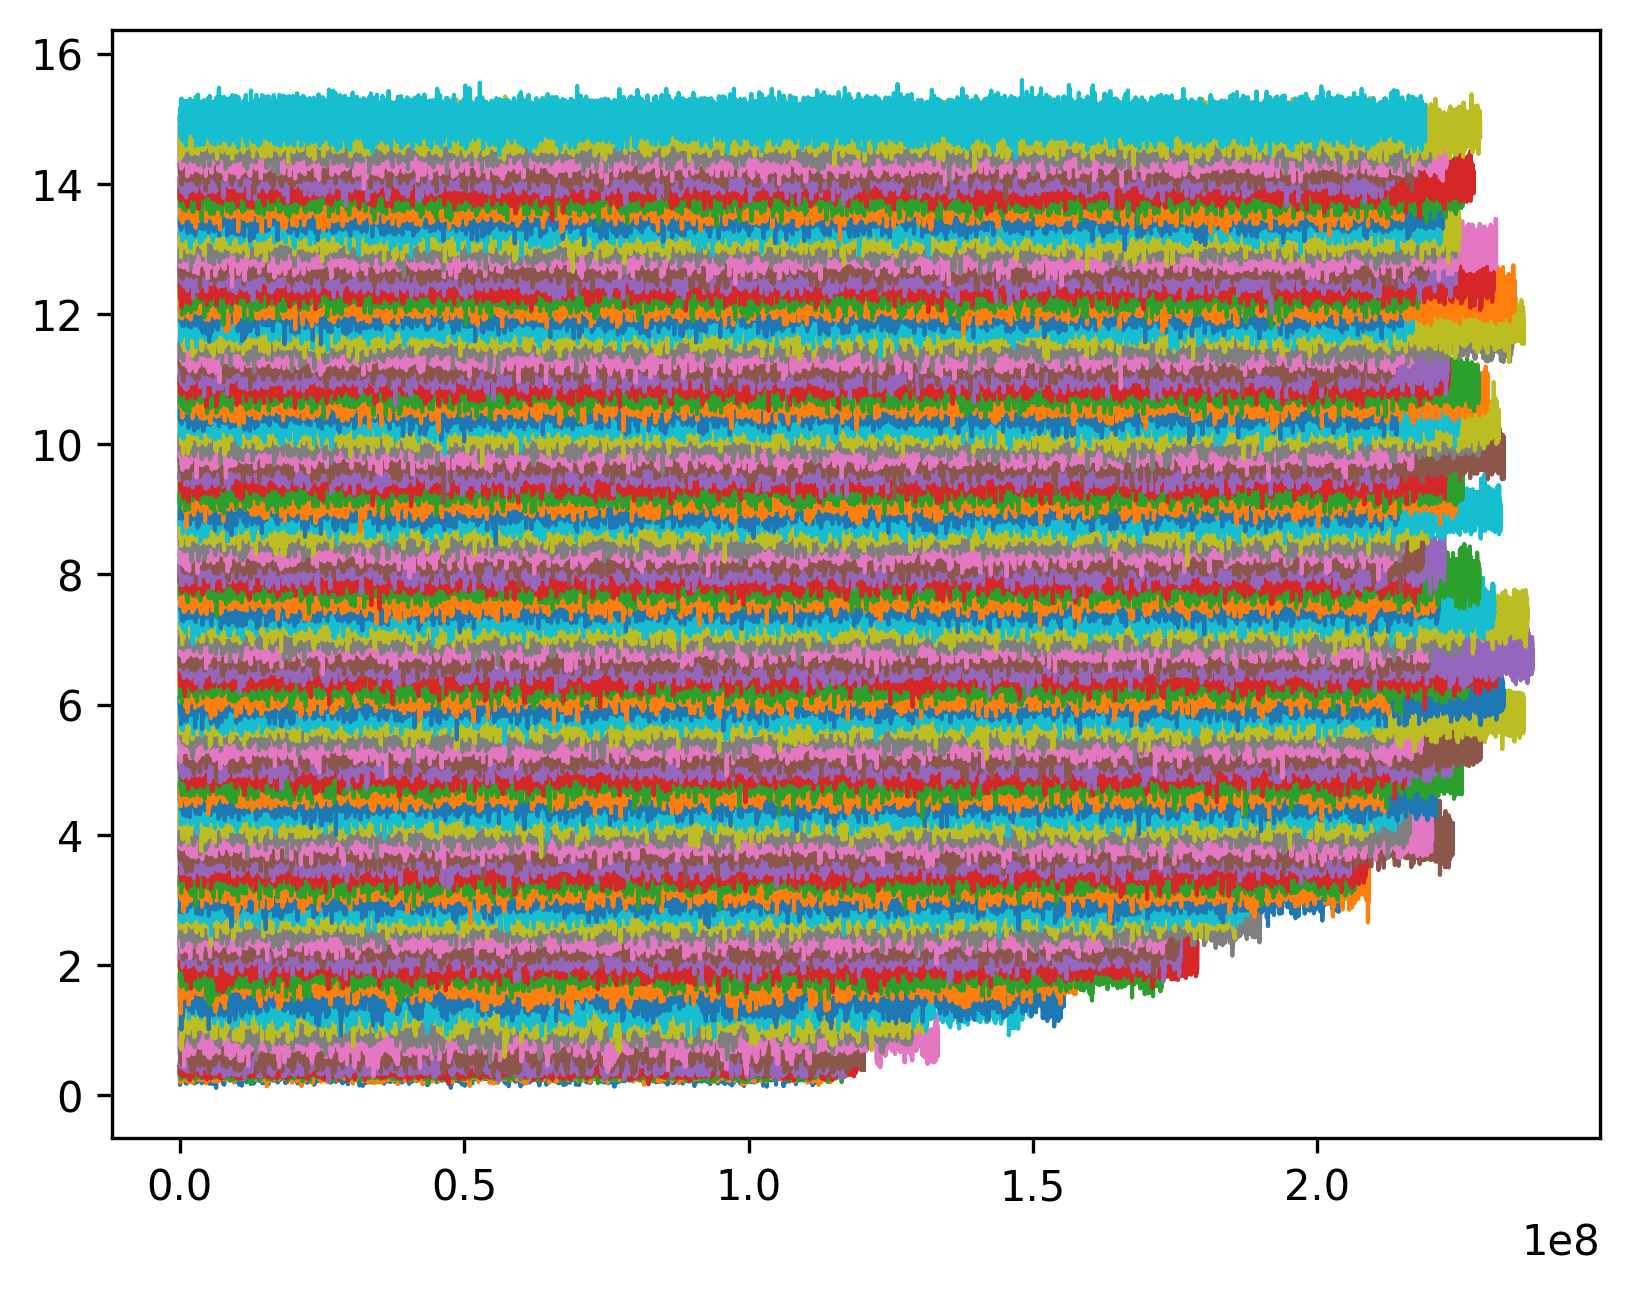

In [7]:
names = ['backbone', 'bonded_excluded_volume', 'stacking', 'nonbonded_excluded_volume', 'hydrogen_bonding', 'cross_stacking', 'coaxial_stacking', 'debye_huckel']
columns = ['com_distance', 'hb_list', 'force_energy', *names]

my_obs = all_observables[0]

fig, ax = plt.subplots(dpi=300)
for idx, obs in enumerate(my_obs):
    plt.plot(obs['steps'], obs['com_distance'].rolling(window=1).mean(), label=f'{idx}', linewidth=1)
# plt.legend(fontsize=1)

(-0.05, 1.05)

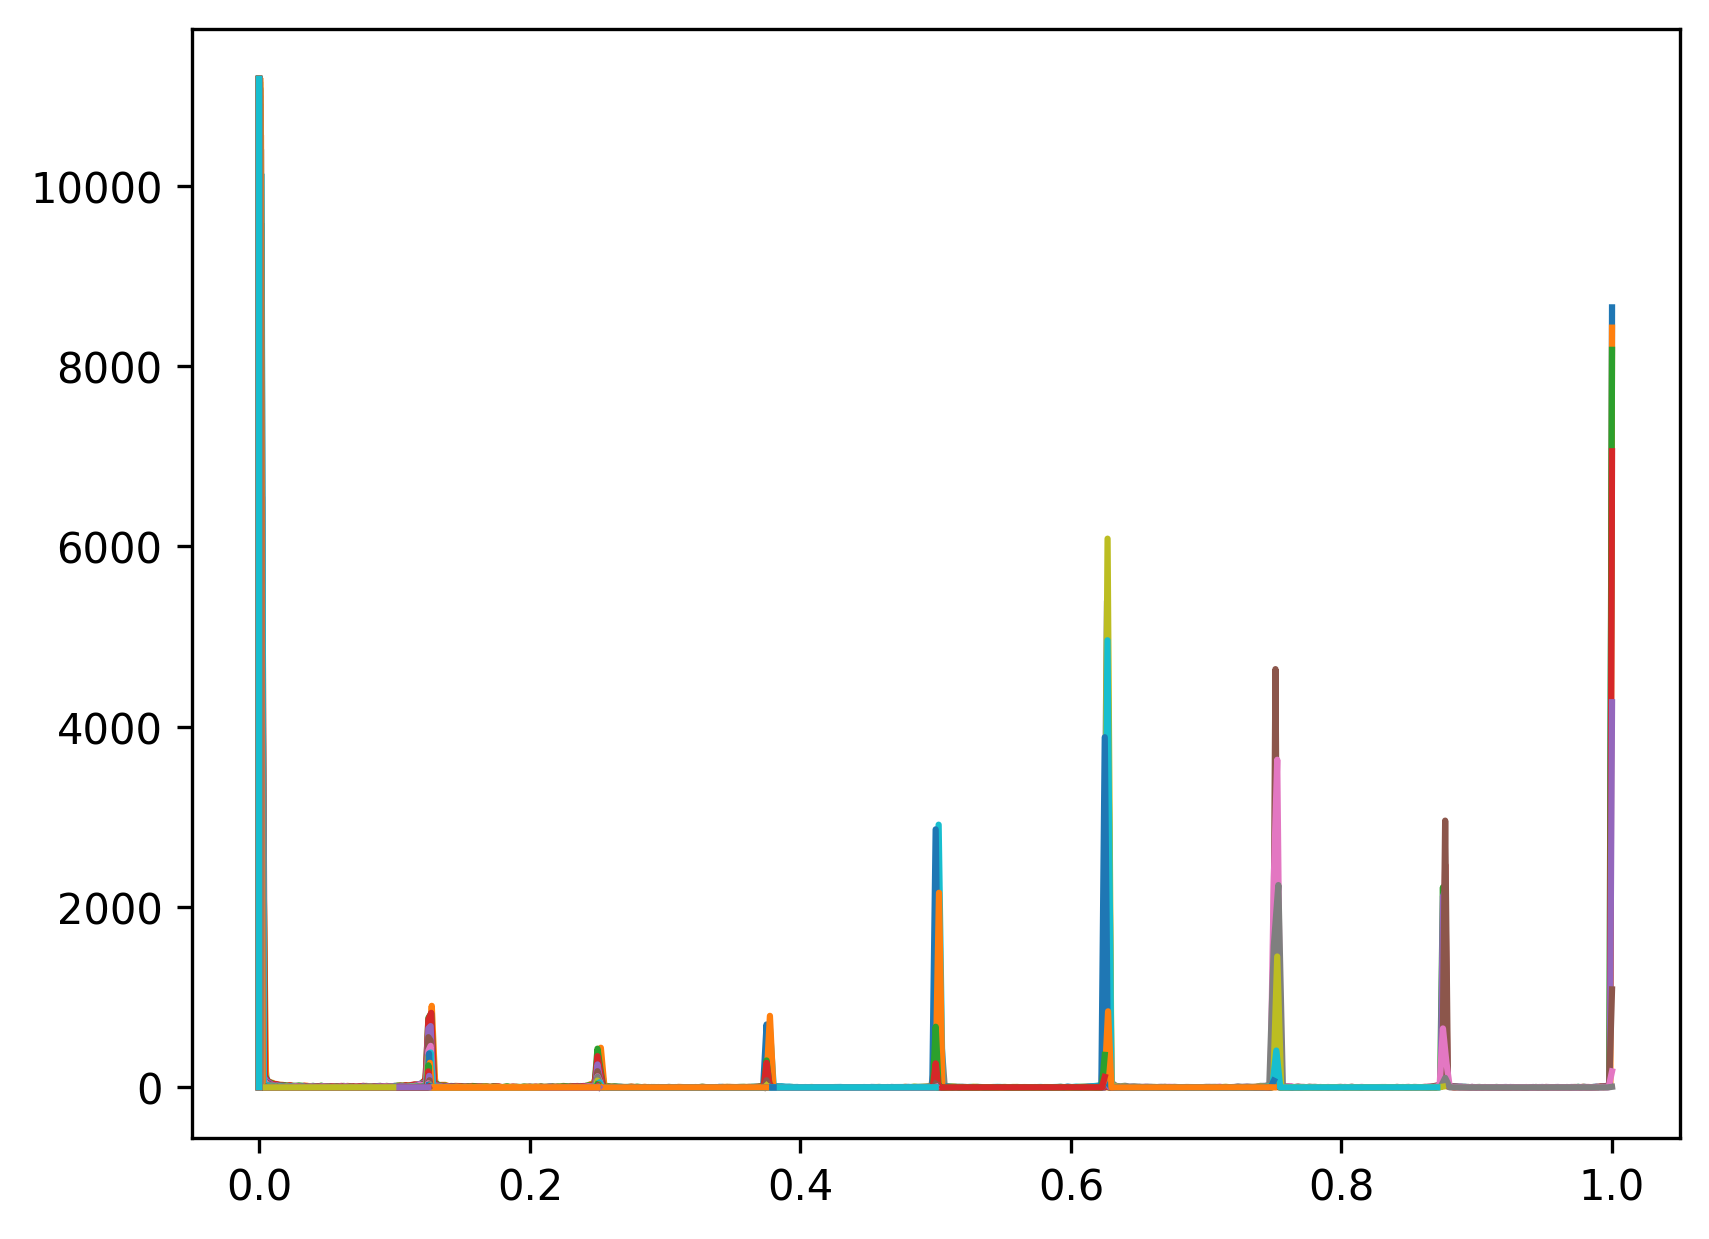

In [8]:
us_list[0].read_hb_contacts(sim_type='prod')

min_len = min([len(inner_list) for inner_list in us_list[0].hb_contacts_by_window.values()])
truncated_hb_contacts_by_window = np.array([value[:min_len] for value in us_list[0].hb_contacts_by_window.values()]).squeeze()

fig, ax = plt.subplots(dpi=300)
for hb_contacts in truncated_hb_contacts_by_window:
    
    H, bins = np.histogram(hb_contacts, bins=300)
    ax.plot(bins[1:], H)
ax.set_xlim(-0.05, 1.05)

In [ ]:
for sim in us_list[0].pre_equlibration_sims[::5]:
    sim.analysis.view_last()

In [23]:
xmin = 0
xmax = 15
# temp_range = np.linspace(45, 65, 41)
# temp_range = np.array([52])
temp_range = np.array([20, 30, 40, 45, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 70, 80])
n_bins = 200
max_hb = 8
epsilon = 1e-5
convergence_slice = 1

us_list[0].wham_cont_and_disc_temp_interp_converg_analysis(convergence_slice, temp_range,
                                                           n_bins, xmin, xmax,max_hb,
                                                           epsilon=epsilon, reread_files=False,
                                                           all_observables=True)

WHAM | 9000/? [01:01<00:00, 146.16it/s, Convergence: 0.000013 / 1e-05]
/scratch/mlsample/ipy_oxDNA/ipy_oxdna/umbrella_sampling.py:1332: RuntimeWarning: divide by zero encountered in log
  free = -np.log(p_x)


Converged in [9644] iterations
64.96993987975952


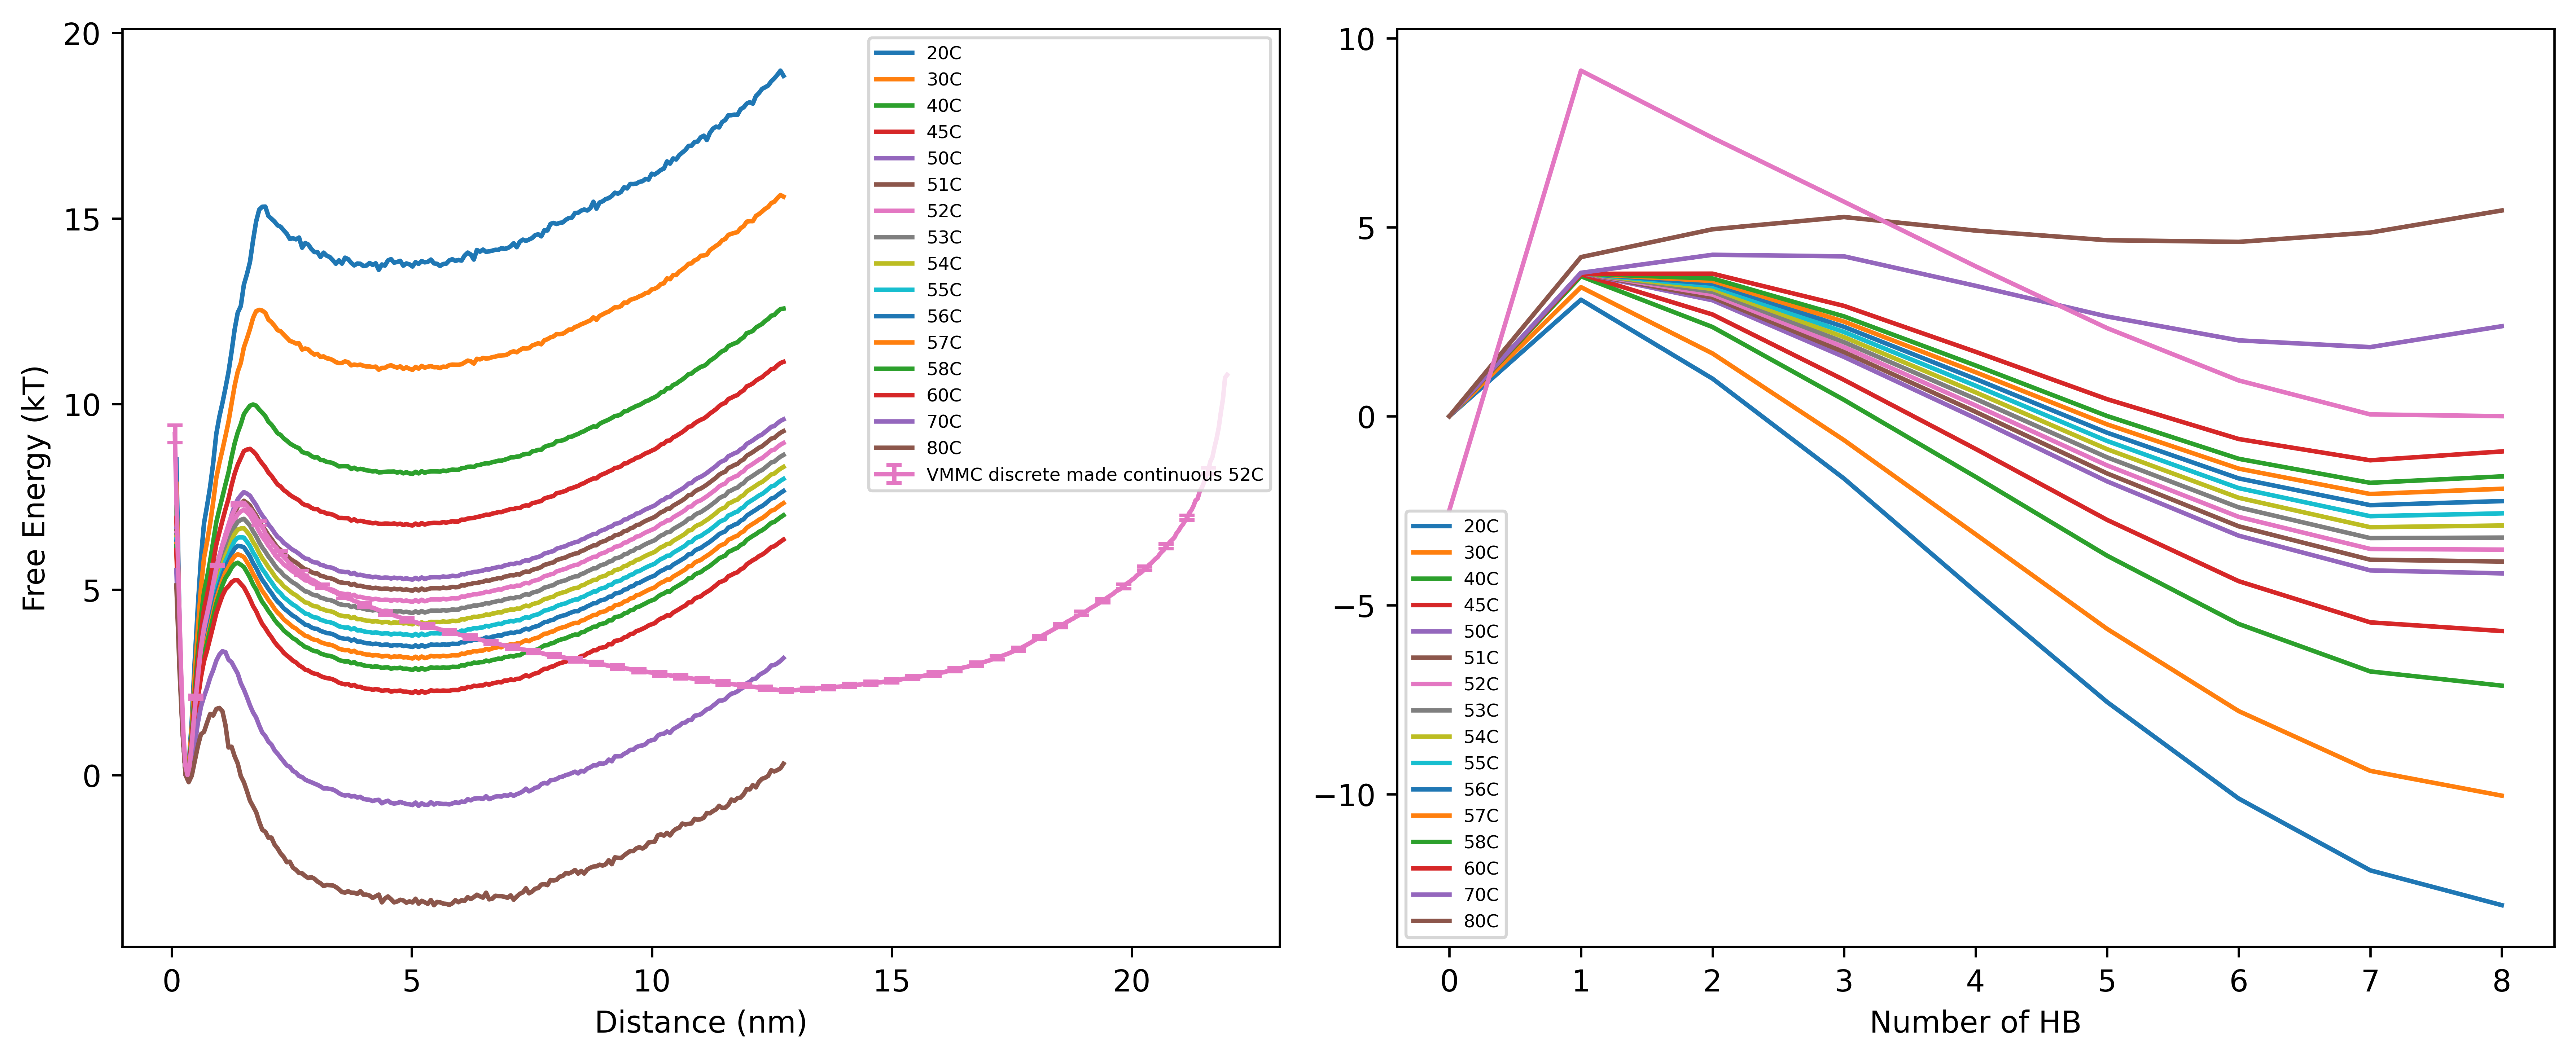

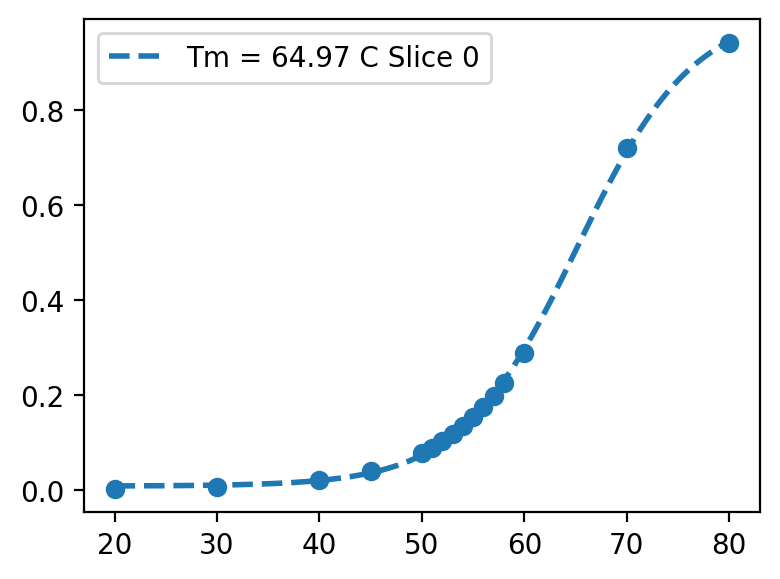

In [24]:
calculated_bin_centers, bin_edges = us_list[0].get_bins(xmin, xmax, n_bins=n_bins)

fig, (ax1, ax2) = plt.subplots(1,2, dpi=600, figsize=(12,5), tight_layout=True)
fig, ax = plt.subplots(dpi=200, figsize=(4,3), tight_layout=True)

ax1.set_xlabel('Distance (nm)')
ax2.set_xlabel('Number of HB')

ax1.set_ylabel('Free Energy (kT)')
# ax2.set_ylabel('Free Energy (kT)')

# ax1.set_xlim(-0.6,14.5)
# ax2.set_xlim(-0.6,29)
# ax1.set_ylim(-0.6,20)

for idx, free in enumerate(us_list[0].convergence_free):            
    sub_index = free[0].argmin()
    for f, temp_val in zip(free, temp_range):
        if idx == 0:
            ax1.plot(calculated_bin_centers*0.8518, f - f[sub_index], label=f'{temp_val}C') 
        else:
            ax1.plot(calculated_bin_centers*0.8518, f - f[sub_index])
vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=500, ax=ax1, confidence_level=0.95, label='VMMC discrete made continuous 52C')

        
ax1.legend(fontsize=6)


for idx, free_discrete in enumerate(us_list[0].convergence_discrete_free_energy):
    for f_discrete, temp_val in zip(free_discrete, temp_range):
        if idx == 0:
            ax2.plot(range(max_hb+1), f_discrete - f_discrete[0], label=f'{temp_val}C')
        else:
            ax2.plot(range(max_hb+1), f_discrete - f_discrete[0])
ax2.legend(fontsize=6)
ax2.plot(range(9), vmmc_sim_list[0].statistics['wt_free'] - vmmc_sim_list[0].statistics['wt_free'].values[-1])
label = ''

for idx, (inverted_finfs, x_fit, y_fit, Tm) in enumerate(zip(us_list[0].convergence_inverted_finfs, us_list[0].convergence_x_fit, us_list[0].convergence_y_fit, us_list[0].convergence_Tm)):
    ax.scatter(temp_range, inverted_finfs, marker='o')
    ax.plot(x_fit, y_fit, linestyle='--', linewidth=2, label=f'Tm = {Tm:.2f} C Slice {idx}')
    # ax.axvline(x=Tm, color='r', linestyle='--', linewidth=2, label=f'{label}Tm = {Tm:.2f} °C')
    ax.legend()   

In [9]:
wham_dir = os.path.abspath('/scratch/mlsample/ipy_oxDNA/wham/wham')
n_bins = '400'
tol = '1e-5'
n_boot = '0'


xmin = [0]
xmax = [15]
n_windows = 100
stiff = 5
print_every = 1e4
temperature = '52C'
name = 'all_observables.txt'

pre_eq_steps = 1e6
eq_steps = 1e8
prod_steps = 1e9

for us in us_list:
    us.observables_list = []
    us.com_distance_observable(com_list, ref_list, print_every=print_every, name=name)
    us.hb_list_observable(print_every=print_every, only_count='true', name=name)
    us.force_energy_observable(print_every=print_every, name=name)
    us.potential_energy_observable(print_every=print_every, name=name)

for us, xmi, xma  in zip(us_list, xmin, xmax):
    us.wham_run(wham_dir, xmi, xma, stiff, n_bins, tol, n_boot, all_observables=True)
    
n_chunks = 2
data_added_per_iteration = 2

for us, xmi, xma  in zip(us_list, xmin, xmax):
    us.wham.get_n_data_per_com_file()
    us.convergence_analysis(n_chunks, data_added_per_iteration, wham_dir, xmi, xma, stiff, n_bins, tol, n_boot)

Running WHAM analysis...
WHAM analysis completed
[0, 10813, 21626]
Running WHAM analysis...
WHAM analysis completed
Running WHAM analysis...
WHAM analysis completed
chunk convergence analysis
[0, 10813, 21626]
Running WHAM analysis...
WHAM analysis completed
Running WHAM analysis...
WHAM analysis completed
chunk convergence analysis


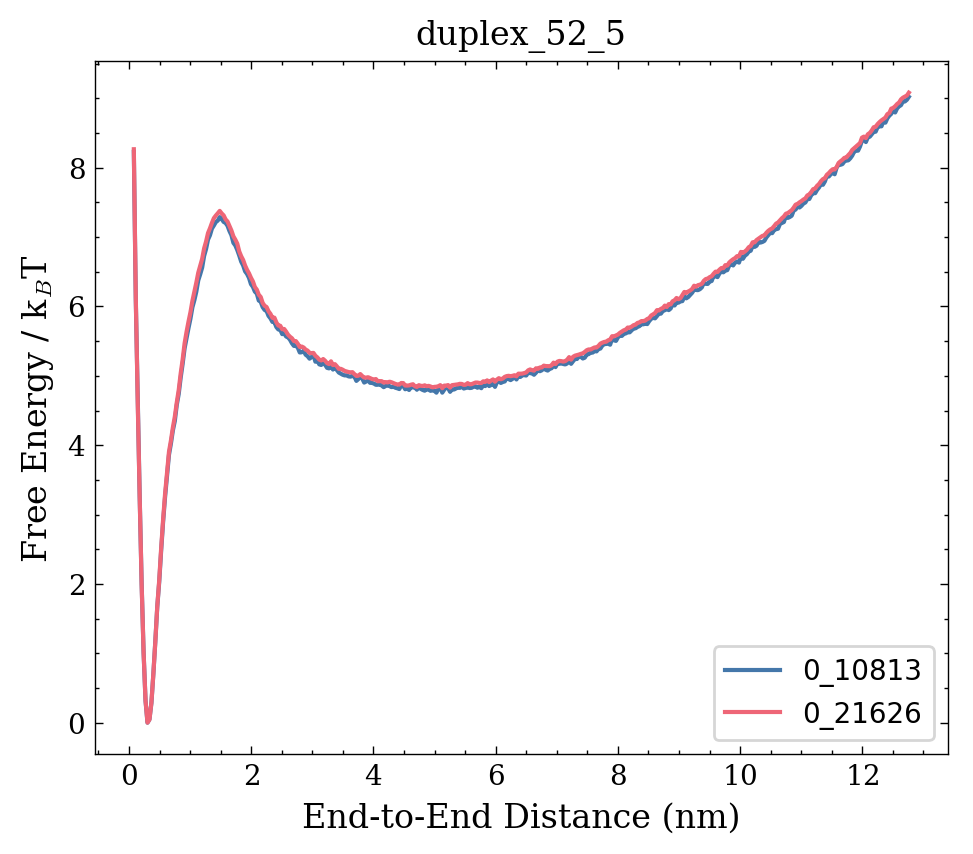

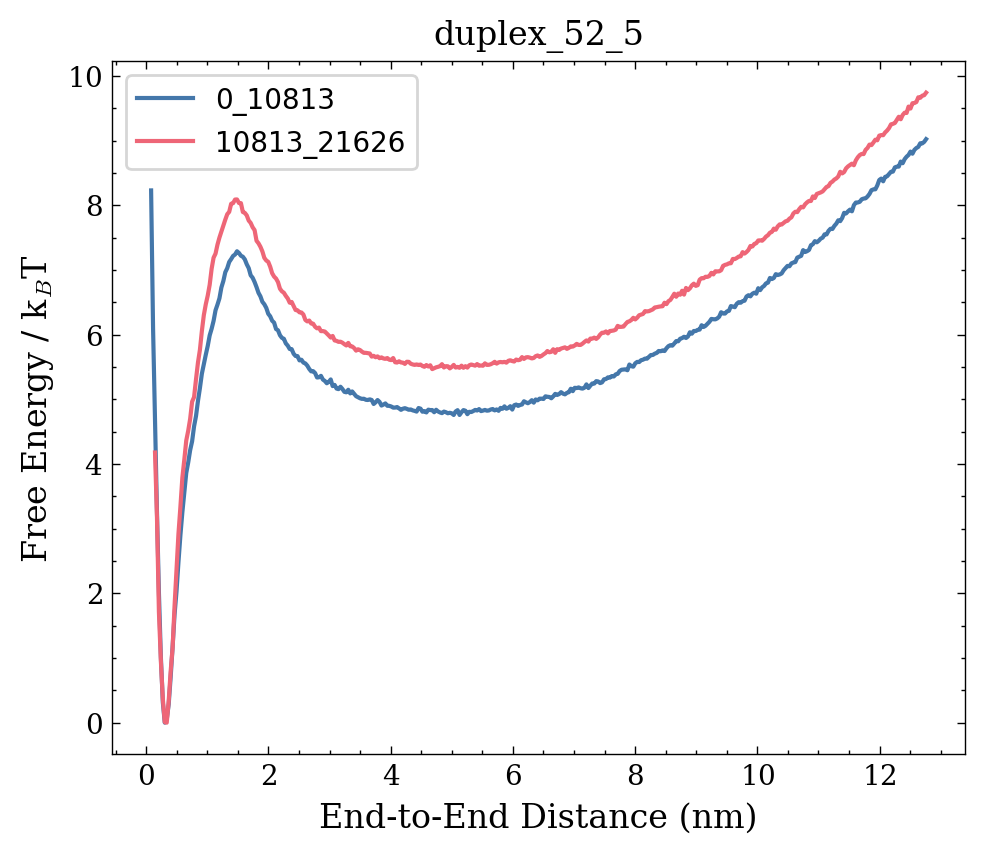

In [10]:
for us in us_list:
    us.wham.plot_truncated_free_energy()
    plt.legend()
    plt.title(us.system)
    us.wham.plot_chunks_free_energy()
    plt.legend()
    plt.title(us.system)

<font size='7'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Initalize Vmmc Replicas</font></h2> 

In [11]:
path = os.path.abspath('/scratch/mlsample/ipy_oxDNA/ipy_oxdna_examples')
systems = ['duplex_melting']

file_dir_list = [f'{path}/{sys}' for sys in systems]
sim_dir_list = [f'{file_dir}/vmmc_melting_replicas/vmmc_melting_rep' for sys, file_dir in zip(systems, file_dir_list)]

n_replicas = 40
vmmc_replica_generator = VmmcReplicas()

vmmc_replica_generator.multisystem_replica(
    systems,
    n_replicas,
    file_dir_list,
    sim_dir_list
)
vmmc_sim_list = vmmc_replica_generator.sim_list
queue_of_simulations = vmmc_replica_generator.queue_of_sims

p1 = '15,14,13,12,11,10,9,8'
p2 = '0,1,2,3,4,5,6,7'
pre_defined_weights = [8, 16204, 1882.94, 359.746, 52.5898, 15.0591, 7.21252, 2.2498, 2.89783]

sim_parameters = {'T':'52C', 'steps':'1e9','print_energy_every': '1e5','print_conf_interval':'1e6'}

In [12]:
vmmc_replica_generatoranalysis.read_vmmc_op_data()
vmmc_sim_list[0].analysis.calculate_sampling_and_probabilities()


In [ ]:
vmmc_replica_generator

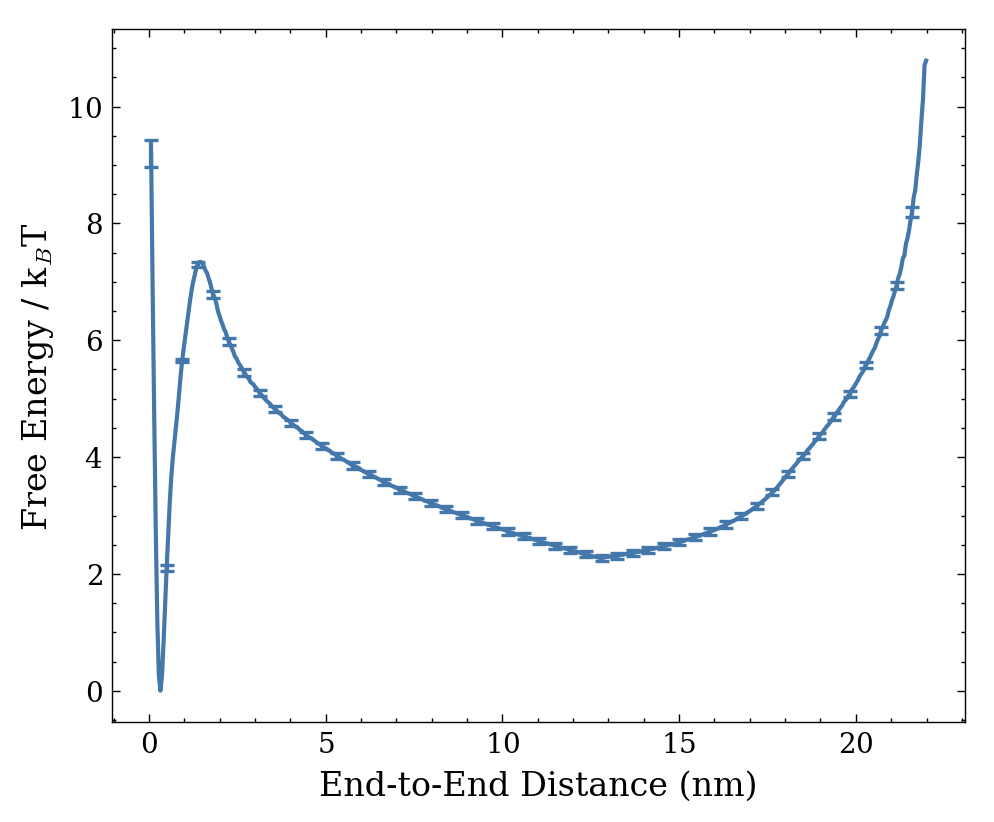

In [14]:
ax = us_list[0].wham.plt_fig()
vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=500, ax=ax, confidence_level=0.95, label='VMMC discrete made continuous 52C')


In [ ]:
with plt.style.context(['science', 'no-latex', 'bright']):
    ax = us.wham.plt_fig() 
    vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=500, ax=ax, confidence_level=0.95, label='VMMC discrete made continuous 52C')
    # us_1.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuous umbrella sampling 52C all bonds')
    us.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuos umbrella sampling 52C only intended bonds')
    ax.set_xlim(-0.1,8)
    plt.ylim(-0.1,9)
plt.legend(fontsize=6)

In [ ]:
with plt.style.context(['science', 'no-latex', 'bright']):
    ax = us.wham.plt_fig() 
    # vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=500, ax=ax, confidence_level=0.95, label='VMMC discrete made continuous 52C')
    us_1.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuous umbrella sampling 52C all bonds')
    us.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuos umbrella sampling 52C only intended bonds')
    # ax.set_xlim(-0.1,8)
    # plt.ylim(-0.1,9)
plt.legend(fontsize=6)